## e-NAS generated network for Image classification on CIFAR-10 dataset

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


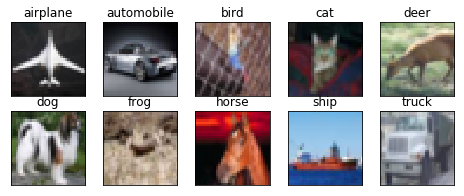

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Types of Convolutions used in eNAS generated network
* Normal Convolution
* Pointwise Convolution
* Depthwise Separable Convolution
* Grouped Convolution

In [0]:
def NormalConv(filters, kernel, input):
  con = Convolution2D(filters, kernel, padding='same')(input)
  act = Activation('relu')(con)
  bat = BatchNormalization()(act)
  return Dropout(0.1)(bat)

def SeparableConv(filters, kernel, input):
  sep =  SeparableConv2D(filters, kernel, padding='same')(input)
  act = Activation('relu')(sep)
  bat = BatchNormalization()(act)
  return Dropout(0.1)(bat)

def GroupConv(input_layer, other_layers):
  input_shape = K.int_shape(input_layer)
  concat_layers = [input_layer]
  for layer in other_layers:
    layer_shape = K.int_shape(layer)
    stride_width = int(round(layer_shape[1]/ input_shape[1]))
    stride_height = int(round(layer_shape[2]/ input_shape[2]))
    filters = int(input_shape[3])
    equal_channels = input_shape[3] == layer_shape[3]

    sampled_layer = layer
    # If shape is different use Pointwise convolution
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        sampled_layer = Convolution2D(
            filters=filters,
            kernel_size=(1, 1),
            strides=(stride_width, stride_height)
        )(layer)
    concat_layers.append(sampled_layer)
  return Concatenate()(concat_layers)

In [16]:
# Define the model
from keras.layers import Input
from keras.layers import Concatenate, AveragePooling2D, BatchNormalization, Dropout, Activation
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras import backend as K
  

inp = Input(shape=(32, 32, 3))

sep_1 = SeparableConv(32, 5, inp)

conv_1 = NormalConv(32, 5, sep_1)

conv_2 = NormalConv(32, 5, conv_1)

group_1 = GroupConv(conv_2, [sep_1])
sep_2 = SeparableConv(32, 5, group_1)

group_2 = GroupConv(sep_2, [sep_1])
max_1 = MaxPooling2D(pool_size=(2, 2))(group_2)

sep_3 = SeparableConv(32, 3, max_1)

group_3 = GroupConv(sep_3, [sep_1, sep_2])
conv_3 = NormalConv(32, 5, group_3)

group_5 = GroupConv(conv_3, [conv_2, sep_2, sep_3])
sep_4 = SeparableConv(32, 3, group_5)

group_6 = GroupConv(sep_4, [conv_3, sep_2, sep_1, sep_3, conv_2])
sep_5 = SeparableConv(32, 5, group_6)

group_7 = GroupConv(sep_5, [sep_4, sep_2, sep_3, sep_1])
max_2 = MaxPooling2D(pool_size=(2, 2))(group_7)

group_8 = GroupConv(max_2, [conv_3])
conv_4 = NormalConv(32, 5, group_8)

group_9 = GroupConv(conv_4, [sep_2, sep_4, conv_1])
sep_6 = SeparableConv(32, 5, group_9)

group_10 = GroupConv(sep_6, [conv_1,conv_2,conv_4,sep_3])
conv_5 = NormalConv(32, 3, group_10)


group_11 = GroupConv(conv_5, [sep_1, conv_2,sep_4,sep_6,sep_3,sep_2])
sep_7 = SeparableConv(32, 5, group_11)

group_12 = GroupConv(sep_7, [sep_6, sep_4, sep_2])
point = Convolution2D(10,8)(group_12)
flatten1 = Flatten()(point)

output = Activation('softmax')(flatten1)

model = Model(inputs=inp, outputs=output)
model.summary()

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_16 (SeparableC (None, 32, 32, 32)   203         input_4[0][0]                    
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 32, 32, 32)   0           separable_conv2d_16[0][0]        
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 32)   128         activation_30[0][0]              
__________________________________________________________________________________________________
dropout_28

#### Run the network & examine output

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 78s 200ms/step - loss: 1.7091 - acc: 0.4416 - val_loss: 1.4666 - val_acc: 0.5114

Epoch 00001: val_acc improved from -inf to 0.51140, saving model to best_weights.hdf5
Epoch 2/100
390/390 [==============================] - 70s 179ms/step - loss: 1.2629 - acc: 0.5693 - val_loss: 1.3530 - val_acc: 0.5613

Epoch 00002: val_acc improved from 0.51140 to 0.56130, saving model to best_weights.hdf5
Epoch 3/100
390/390 [==============================] - 69s 177ms/step - loss: 1.0619 - acc: 0.6318 - val_loss: 1.0742 - val_acc: 0.6386

Epoch 00003: val_acc improved from 0.56130 to 0.63860, saving model to best_weights.hdf5
Epoch 4/100
390/390 [==============================] - 70s 179ms/step - loss: 0.9320 - acc: 0.6776 - val_loss: 0.9140 - val_acc: 0.6905

Epoch 00004: val_acc improved from 0.63860 to 0.69050, saving model to best_weights.hdf5
Epoch 5/100
390/390 [==============================] - 70s 179ms/step - loss: 0.8337 - acc: 0.7125 - val_loss: 

### Observing the network

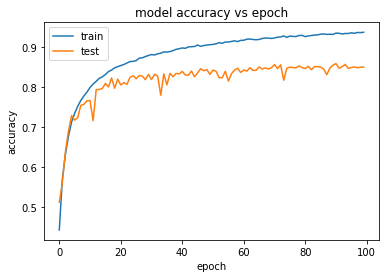

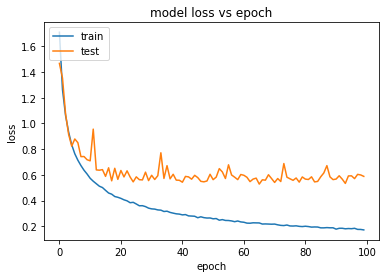

In [20]:
import matplotlib.pyplot as plt

history= model_info

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss vs epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Obviously above needs some tuning to fix over-fitting issue seen